### Save contextualized vectors 

In [29]:
import json, os
from proteinbert import load_pretrained_model
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs
import numpy as np

ALL_AAS = 'ACDEFGHIKLMNPQRSTUVWXY'

seq_len = 3072
pretrained_model_generator, input_encoder = load_pretrained_model()
model = get_model_with_hidden_layers_as_outputs(pretrained_model_generator.create_model(seq_len))

seq_path = "C:\\Users\\efeka\\Documents\\GitHub\\549-term-project\\alignment\\all_sequences.json"

with open(seq_path, 'r') as f:
    sequences = json.load(f)

vector_list = []
local_rep_aa_list = []
index = 0
for sequence in sequences:
    ref = sequence.split('-')[0]
    msa = sequence.split('-')[1]
    sequence_name = sequence.split('-')[2]
    #if ref == "RV912":
    #print(sequence)
    #index +=1
    #if index == 300:
    #    break
    seq_t = sequences[sequence]

    encoded_x = input_encoder.encode_X([seq_t], seq_len)
    local_representations, _ = model.predict(encoded_x, batch_size = 1, verbose = 0)

    # SPECIAL TOKENS: 22: UNK, 23: BOS, 24: EOS, 25: PAD
    #mask_to_exclude_special_tokens =  encoded_x[0][0] < 23 # exclude 23: BOS, 24: EOS, 25: PAD
    #local_rep = local_representations[0][mask_to_exclude_special_tokens]

    mask_to_include_aa =  encoded_x[0][0] < 23 # exclude 23: BOS, 24: EOS, 25: PAD 
    local_rep = local_representations[0][mask_to_include_aa]
    
    for vector in local_rep:
        # Convert the 1D array to a Python list and append to vector_list
        vector_list.append(vector[-154:-26])
    
    for aa_index in encoded_x[0][0][mask_to_include_aa]:
        local_rep_aa_list.append(aa_index)
        
#np.savetxt(f"output_representations/{ref}/{msa}/{sequence_name}.txt", local_rep)
np.savetxt(f"vector_list.txt", vector_list)
np.savetxt(f"local_rep_aa_list.txt", local_rep_aa_list)


### Clustering

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib import cm
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

In [1]:
ALL_AAS = 'ACDEFGHIKLMNPQRSTUVWXY'
vector_list = np.loadtxt("vector_list.txt")
local_rep_aa_list = np.loadtxt("local_rep_aa_list.txt")

In [27]:
vector_list = np.array(vector_list)
local_rep_aa_list = np.array(local_rep_aa_list,dtype=int)
print(vector_list.shape, local_rep_aa_list.shape)
aa_dict = {}

(764769, 128) (764769,)


In [74]:
np.unique(local_rep_aa_list)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       18, 19, 20, 21])

#### PCA plot

In [ ]:

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(vector_list)

764769


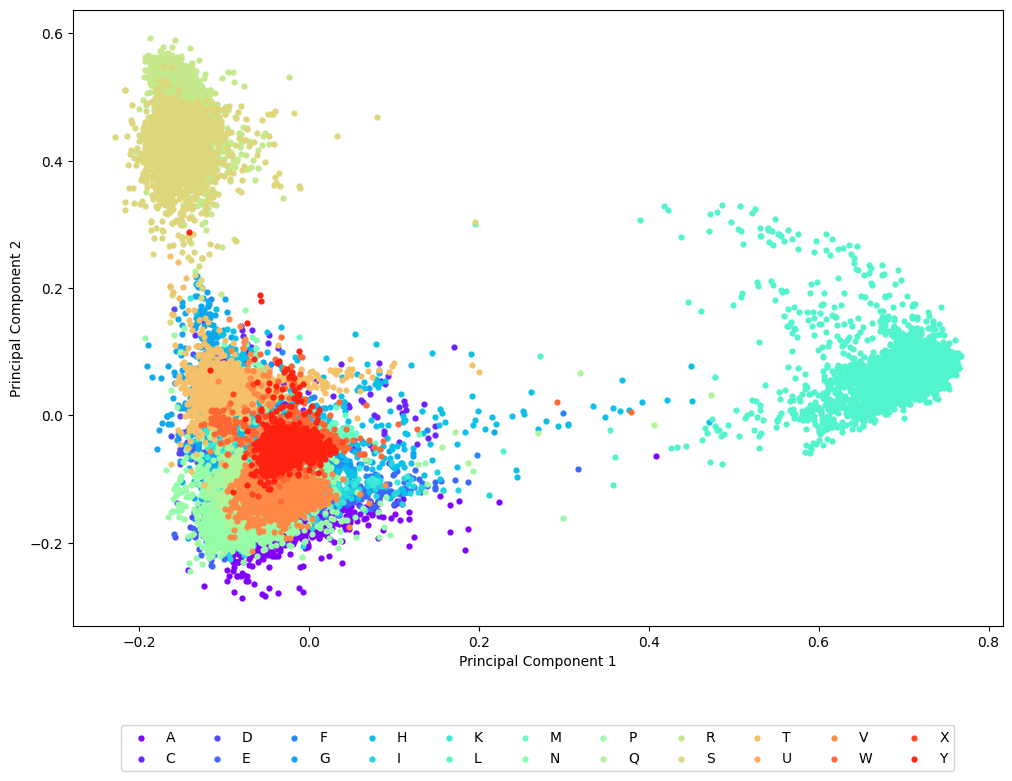

In [68]:
plt.figure(figsize=(12, 8))
markersize = 12
num_colors = 22
colors = [cm.rainbow(i/num_colors) for i in range(num_colors)]
index = 0
for i in range(len(ALL_AAS)):
    aa_indices = np.where(local_rep_aa_list == i )
    plt.scatter(principal_components[aa_indices[0], 0], principal_components[aa_indices[0], 1], color = colors[i], s=markersize,label = ALL_AAS[i] )
    index += len(aa_indices[0])
print(index)
#plt.title('PCA Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=11)
plt.show()

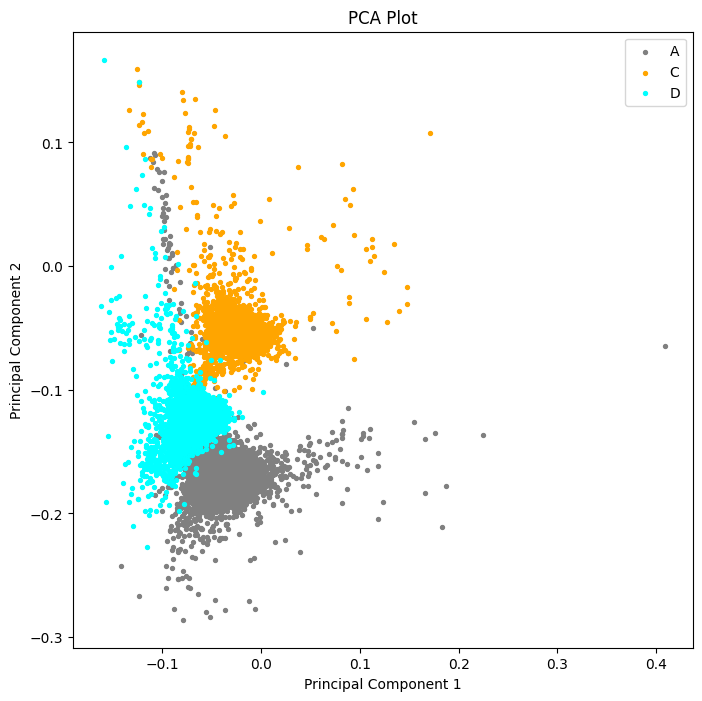

In [44]:
plt.figure(figsize=(8, 8))
markersize = 8
A_indices = np.where(local_rep_aa_list ==0)
plt.scatter(principal_components[A_indices, 0], principal_components[A_indices, 1], c = "gray", s=markersize,label = "A" )
C_indices = np.where(local_rep_aa_list ==1)
plt.scatter(principal_components[C_indices, 0], principal_components[C_indices, 1], c = "orange", s=markersize ,label = "C" )
D_indices = np.where(local_rep_aa_list ==2)
plt.scatter(principal_components[D_indices, 0], principal_components[D_indices, 1], c = "cyan", s=markersize,label = "D" )
#legend_elements = []
# Get the list of colors

#for i in range(num_colors):
#    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=ALL_AAS[i],markerfacecolor=colors[i], markersize=8))
plt.title('PCA Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# produce a legend with the unique colors from the scatter
plt.legend()
plt.show()

#### Silhouette Analysis

In [75]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(vector_list)


In [71]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define a range of k values
k_values = range(20,21)

# Initialize lists to store silhouette scores for each k
silhouette_scores = []

# Iterate over each k value
for k in k_values:
    # Fit KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42,verbose=1)
    cluster_labels = kmeans.fit_predict(vector_list)

cluster_labels


c:\Users\efeka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 69035.1910514057.
Iteration 1, inertia 51398.29029750058.
Iteration 2, inertia 51387.79435698592.
Iteration 3, inertia 51385.33691725058.
Iteration 4, inertia 51384.528443742936.
Iteration 5, inertia 51384.282492980805.
Iteration 6, inertia 51384.17988955361.
Iteration 7, inertia 51384.13022914296.
Iteration 8, inertia 51384.095293480095.
Iteration 9, inertia 51384.07971910503.
Converged at iteration 9: center shift 2.548869656103366e-07 within tolerance 3.9925032940447015e-07.
Initialization complete
Iteration 0, inertia 69882.10886294657.
Iteration 1, inertia 48911.54555104303.
Iteration 2, inertia 48911.46499215986.
Converged at iteration 2: center shift 6.69467902821294e-09 within tolerance 3.9925032940447015e-07.
Initialization complete
Iteration 0, inertia 103848.94395064365.
Iteration 1, inertia 63979.50246705476.
Iteration 2, inertia 63879.61317746782.
Iteration 3, inertia 63856.27123365532.
Iteration 4, inertia 63847.83739188868.
It

array([2, 7, 0, ..., 0, 9, 3])

In [73]:
len(cluster_labels)

764769

In [ ]:


# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42,perplexity=40)
tsne_result = tsne.fit_transform(vector_list[:10000])

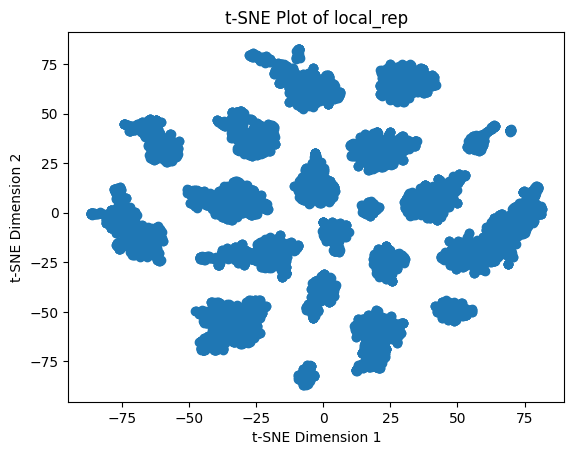

In [6]:


# Plot the t-SNE results
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE Plot of local_rep')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [1]:
# Plot the t-SNE results
plt.scatter(tsne_result[:, 0], tsne_result[:, 1],c=local_rep_aa_list[:10000], cmap="tab20", s=3)
plt.title('t-SNE Plot of local_rep')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


NameError: name 'plt' is not defined